In [11]:
#importing required tools for powerflow analysis
import pandas as pd
import numpy as np
import pandapower as pp
import pandapower.networks as pn
import matplotlib.pyplot as plt
import geopandas
import math
from pandapower.plotting.plotly import simple_plotly

#importing and running GBreducednetwork powerflow
net = pn.GBreducednetwork()
pp.runpp(net)

In [12]:
#Saving network to Excel for analysis of componenets if required
pp.to_excel(net,'UK_Network_Original.xlsx')

In [13]:
#Calcualting the load of the GBreduced network
pq_load= ((net.load.p_mw)**2 + (net.load.q_mvar)**2)**0.5
pq_load_sum=pq_load.sum()

#Establishing scaling required to represent worst-case loading of the system
scaling_factor= 61000/pq_load_sum

#Printing update to user. This explains the scaling used in further analysis
print("Load in the UK_Case is",int(pq_load_sum),"MW.")
print("Whereas the peak load experienced in the UK is 61000 MW (National Grid, 2017)") #http://fes.nationalgrid.com/media/1264/ev-myth-buster-v032.pdf
print("To replicate peak loading of the system, load and generation in the UK_Case is multipled by","{0:.4f}.".format(scaling_factor))
print("This load is replicated using the scaling functionality in Pandapower.")

#Create empty dataframe for analysis
df1=pd.DataFrame()

#Scaling system to represent worst-case loads
net.load.scaling=scaling_factor
net.gen.scaling=scaling_factor
net.sgen.scaling=scaling_factor 

#Saving the scaled network to Excel for further analysis if required
pp.to_excel(net,'UK_Network_Scaled.xlsx')

#This block of code removes each line in turn, and runs powerflow analysis to analsye the impact that removing a specific line has. 
x = range(0,86)
for line in x:
    
    pp.drop_lines(net,lines=[line])

    try:
        pp.runpp(net)
        
        #Powerflow results recorded when each line is removed as follows:        
        #   - Three highest loading percents of lines within system and corresponding indexes
        loading_percent = (net.res_line.loading_percent)
        loading_percent_max = loading_percent.nlargest(3)
        df1.at[line,'first_loading_percent_max'] = float(loading_percent_max.iloc[0])
        df1.at[line,'first_loading_percent_max_index'] = float(loading_percent_max.index[0])
        df1.at[line,'second_loading_percent_max'] = float(loading_percent_max.iloc[1])
        df1.at[line,'second_loading_percent_max_index'] = float(loading_percent_max.index[1])
        df1.at[line,'third_loading_percent_max'] = float(loading_percent_max.iloc[2])
        df1.at[line,'third_loading_percent_max_index'] = loading_percent_max.index[2]
        
        #   - Number of lines in the system with a loading percent above 100%
        loading_percent_exceed_100_occurance = sum(i >100 for i in loading_percent)
        df1.at[line,'loading_percent_exceed_100_occurance'] = float(loading_percent_exceed_100_occurance)
        
        #   - Sum of the power within all lines in the system
        line_power = abs(net.res_line.p_from_mw)
        line_power_sum = line_power.sum()
        df1.at[line,'line_power_sum'] = float(line_power_sum)
        
        #   - Maximum power occuring within any one line, with corresponding line index
        line_power = abs(net.res_line.p_from_mw)
        line_power_max = line_power.max()
        df1.at[line,'line_power_max'] = float(line_power_max)
        line_power_max_index = line_power.idxmax()
        df1.at[line,'line_power_max_index'] = line_power_max_index
       
        #   - Highest / lowest voltage per unit the end of a line within the system
        volt_magto =(net.res_line.vm_to_pu)
        volt_magto_min = volt_magto.min()
        df1.at[line,'volt_magto_min'] = float(volt_magto_min)
        volt_magto_max = volt_magto.max()
        df1.at[line,'volt_magto_max'] = float(volt_magto_max)
        
        #   - Highest / lowest voltage per unit the beginning of a line within the system
        volt_magfrom =(net.res_line.vm_from_pu)
        volt_magfrom_min = volt_magfrom.min()
        df1.at[line,'volt_magfrom_min'] = float(volt_magfrom_min)
        volt_magfrom_max = volt_magfrom.max()
        df1.at[line,'volt_magfrom_max'] = float(volt_magfrom_max)
        
    except:
        #Error blocking ensures that the powerflow analysis is run when a single line does not converge. 
        #When the flow does not converge "0" is recorded and analysis is continued.
        error_variable = float("0")
        df1.at[line,'first_loading_percent_max'] = error_variable
        df1.at[line,'first_loading_percent_max_index'] = error_variable
        df1.at[line,'second_loading_percent_ave'] = error_variable
        df1.at[line,'second_loading_percent_max_index'] = error_variable
        df1.at[line,'third_loading_percent_max'] = error_variable
        df1.at[line,'third_loading_percent_max_index'] = error_variable  
        df1.at[line,'line_power_sum'] = error_variable
        df1.at[line,'line_power_max'] = error_variable
        df1.at[line,'line_power_max_index'] = error_variable
        df1.at[line,'volt_magto_max'] = error_variable
        df1.at[line,'volt_magfrom_max'] = error_variable
        df1.at[line,'volt_magto_min'] = error_variable
        df1.at[line,'volt_magfrom_min'] = error_variable
    
    #Replacing the line removed, and re-scaling the system to replicate worst-case loading before the loop is ran again.
    net = pn.GBreducednetwork()
    net.load.scaling=scaling_factor
    net.gen.scaling=scaling_factor
    net.sgen.scaling=scaling_factor
    
    #This analysis will finish when every line in the system has been removed, and the above data is recorded for each scenario. 

Load in the UK_Case is 58712 MW.
Whereas the peak load experienced in the UK is 61000 MW (National Grid, 2016)
To replicate peak loading of the system, load and generation in the UK_Case is multipled by 1.0390.
This load is replicated using the scaling functionality in Pandapower.


In [14]:
#Saving results to CSV for analysis
df1.to_csv('UK_Network_Line_Results.csv')

In [15]:
#Calculating the loads experienced by each line under worst-case operating conditions
net = pn.GBreducednetwork()
net.load.scaling=scaling_factor
net.gen.scaling=scaling_factor
net.sgen.scaling=scaling_factor
pp.runpp(net)

power_from=((net.res_line.p_from_mw**2)+(net.res_line.q_from_mvar**2))**0.5
power_to=(((net.res_line.p_to_mw)**2)+((net.res_line.q_to_mvar)**2))**0.5

#Saving results to excel for analysis
power_from.to_excel('powerfromline.xlsx')
power_to.to_excel('powertoline.xlsx')

#The below sorting could be used to analyse the lines with the largest loads in the python module
#power_from.sort_values()
#power_to.sort_values()

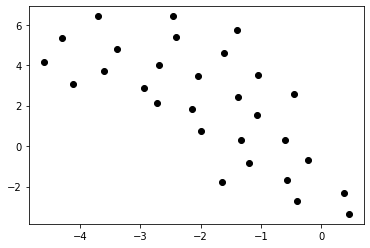

In [8]:
#Plot the busses in python - not extremely meaningful due to the coordinate system used. Spatial analysis in QGIS is now performed.
x = net.bus_geodata.x
y = net.bus_geodata.y
plt.plot(x, y, 'o', color='black')

In [19]:
#Analysis of the voltage magnitude of busses, when each line is removed

net = pn.GBreducednetwork()
net.load.scaling=scaling_factor
net.gen.scaling=scaling_factor
net.sgen.scaling=scaling_factor
df2=pd.DataFrame()

y = range(0,86)
for line in y:
    
    pp.drop_lines(net,lines=[line])

    try:
        pp.runpp(net)
        
        #Calculating the three largest bus voltages per unit, with corresponding indexes when each line is removed 
        bus_voltage = (net.res_bus.vm_pu)
        bus_voltage_max = bus_voltage.nlargest(3)
        df2.at[line,'first_bus_voltage_max'] = float(bus_voltage_max.iloc[0])
        df2.at[line,'first_bus_voltage_max_index'] = float(bus_voltage_max.index[0])
        df2.at[line,'second_bus_voltage_max'] = float(bus_voltage_max.iloc[1])
        df2.at[line,'second_bus_voltage_max_index'] = float(bus_voltage_max.index[0])
        df2.at[line,'third_bus_voltage_max'] = float(bus_voltage_max.iloc[2])
        df2.at[line,'third_bus_voltage_max_index'] = float(bus_voltage_max.index[2])
        
        #Calculating the three smallest bus voltages per unit, with corresponding indexes when each line is removed 
        bus_voltage_min = bus_voltage.nsmallest(3)
        df2.at[line,'first_bus_voltage_min'] = float(bus_voltage_min.iloc[0])
        df2.at[line,'first_bus_voltage_min_index'] = float(bus_voltage_min.index[0])
        df2.at[line,'second_bus_voltage_min'] = float(bus_voltage_min.iloc[1])
        df2.at[line,'second_bus_voltage_min_index'] = float(bus_voltage_min.index[0])
        df2.at[line,'third_bus_voltage_min'] = float(bus_voltage_min.iloc[2])
        df2.at[line,'third_bus_voltage_min_index'] = float(bus_voltage_min.index[2])
    
    except:
        #Error blocking ensures that the powerflow is completed. 
        #When the flow does not converge "0" is recorded and analysis is continued.
        error_variable = float("0")
        df2.at[line,'first_bus_voltage_max'] = error_variable
        df2.at[line,'first_bus_voltage_max_index'] = error_variable
        df2.at[line,'second_bus_voltage_max'] = error_variable
        df2.at[line,'second_bus_voltage_max_index'] = error_variable
        df2.at[line,'third_bus_voltage_max'] = error_variable
        df2.at[line,'third_bus_voltage_max_index'] = error_variable
        
        df2.at[line,'first_bus_voltage_min'] = error_variable
        df2.at[line,'first_bus_voltage_min_index'] = error_variable
        df2.at[line,'second_bus_voltage_min'] = error_variable
        df2.at[line,'second_bus_voltage_min_index'] = error_variable
        df2.at[line,'third_bus_voltage_min'] = error_variable
        df2.at[line,'third_bus_voltage_min_index'] = error_variable

#Saving bus results to csv for further analysis        
df2.to_csv('UK_Network_Bus_Results.csv')
